<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Material_Predicting_Beam_Profile_in_Synchrotron_Beam_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Predicting beam profile in synchrotron beam using LSTM

In this notebook, we attempt to build a time series model to predict the profile of the beam, specifically the RMS of the x-coordinate profile.


The data in this example has several parameters as inputs.  We have the horizontal and vertical control of the injector that control the incoming beam. We also have the time that the acceleration has been running for and finally we have an estimate of the number of the profile.


The aim of this work is to take the results of the low cost simulation and to use the LSTM make them match more closely to the high cost accurate simulation - which is your ground truth Y values in this example. To give a sense of the sppedup, the low cost simulations take about 1 second to run, the ground truth simulations take about 16 hours each.

The data for this practical is plotted below. On the left you can see the vertical and horizontal injector control paramaters. On the right you can see the X$_{RMS}$ from the low cost model and those from the full physics simulation.

<img src="https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/lstm-practical-data.png?raw=1" alt="lstm-practical-data" width="900"/>

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


### Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Material')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Material/"
files_to_download = ["injector-data.csv"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The data has been preprocessed a bit - so the values are all normalised to between 0 and 1. Use `pandas` to read the csv `Material/injector-data.csv`

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
data = pd.read_csv(join(data_path,'Material/injector-data.csv'))
```
    
</p>
</details>


In [4]:
data = pd.read_csv(join(data_path,'Material/injector-data.csv'))

### Our data processing for LSTM function

In order to provide data to LSTM, we need to convert data to time series.

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    The function automatically checks if we are dealing with a univariate or a multi-variate problem, by
    checing the shape and type of `data`.
    Adapted from: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    Arguments:
       data: Sequence of observations as a list or NumPy array.
       n_in: Number of lag observations as input (X).
       n_out: Number of observations as output (y).
       dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
       Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Split into x and y values

In this example the coluumns 1-4 of the data are the input variables and column 5 is the value we wish to predict. In the first instance we will just use the first 100000 data points to train the model. Limiting the data this way results in over-fitting, **but** it will allow us to get the model working and training in a reasonable time.

When we are happy that the model is actually training and learning (albeit over-fitting) we can return and add more data.

In [6]:
data_limit = 100000
values = data.values
xvalues = values[:data_limit, 1:5]
yvalues = values[:data_limit, 5]

### Refreame the training data

Use the `series_to_supervised` function to convert the `xvalues` to a datframe called `reframedx` which has a past window of 0 steps into the past and a future prediction window of 1 step.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
reframedx = series_to_supervised(xvalues, 0, 1)
```
    
</p>
</details>


In [7]:
reframedx = series_to_supervised(xvalues, 0, 1)

### Convert to arrays for training

We now reshape the `reframedx` to work with the netword. **Note** we also need to remove the first $n$ values from the y data, where $n$ is the size of the window defined above. When you are tyring different window sizes in future, don't forget to alter this value.

In [8]:
past_steps = 0
x_train = reframedx.values
x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
y_train = yvalues[past_steps:]

---

# 2. Build the network

We will build a network with LSTM layer. The first layer is a LSTM layer and it takes a time seris input. Hence, the input shape should be (n of time stamp, n of features). Then, the last layer of the network should output one target feature.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# Initialising the LSTM
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

# Adding the output layer
model.add(Dense(1))
print(model.summary())
```
    
</p>
</details>


In [9]:
# Initialising the LSTM
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

# Adding the output layer
model.add(Dense(1))
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


## Compile and fit the network

Compile the network to use `mae` as the loss and `adam` as the optimiser.

For training initially run for 30 epochs with a batch size of 128 and a validation split of 0.2. Set `shuffle` to `False` for the fitting.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, epochs=30,
                    batch_size=128, validation_split=0.2,
                    shuffle=False,callbacks=[stopper])
```
    
</p>
</details>

In [10]:
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, epochs=30,
                    batch_size=128, validation_split=0.2,
                    shuffle=False,callbacks=[stopper])

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1508 - val_loss: 0.0400
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0584 - val_loss: 0.0450
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0540 - val_loss: 0.0438
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


---

# 3. Analyse results

## Take a look at some results

We can look at how the model peroforms on the training set and on an independent test set.

### Training set

First see how we are doing on the training data - if you cannot fit the training data there is no hope on anything else.
By chaniging the value of `index` below we can choose different samples from the training set.

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(0.0, 660.0)

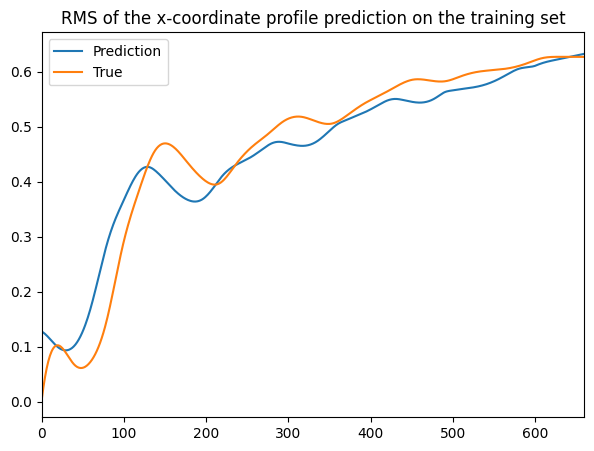

In [11]:
index = 1
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
y_pred = model.predict(x_train[(index-1)*786+100:index*786])
plt.plot(y_pred[:, 0], label='Prediction')
plt.plot(y_train[(index-1)*786:index*786], label='True')
plt.title('RMS of the x-coordinate profile prediction on the training set')
plt.legend()
plt.xlim(0, 660)

### Independent test set

If the model worked okay on the training data a true test is on independent data that was not used for training.

**Note** you will have to alter window size here to match your training data.

In [12]:
window_size = 0
values = data.values
xtestvalues = values[370913:, 1:5]
ytestvalues = values[370913:, 5]
reframedxtest = series_to_supervised(xtestvalues, window_size, 1)
x_test = reframedxtest.values
x_test = x_test.reshape((x_test.shape[0], 4, x_test.shape[1]//4))
y_test = ytestvalues[window_size:]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(100.0, 680.0)

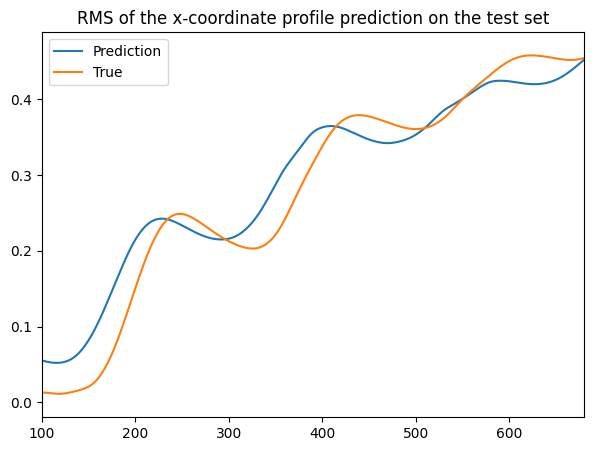

In [13]:
index = 10
y_pred = model.predict(x_test[(index-1)*786:index*786])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(y_pred[100:, 0], label='Prediction')
plt.plot(y_test[(index-1)*786:index*786], label='True')
plt.title('RMS of the x-coordinate profile prediction on the test set')
plt.legend()
plt.xlim(100, 680)

---

# 4. Exercise

The network is running, but the results are not very good. Let's try doing some hyper-parameter tuning.

Here are some things to try:

* Different window sizes
    - [0, 1, 2, 5, 10]
    - Use just 30 epochs for each of these
    
* Increase the number of LSTM layers
    - 1, 2, 3 layers of lstm
    - Use just 30 epochs for each of there
    
When you have found the best options - try to increase the training dataset to 400000 and leave the model to train for 1000 epochs. This will probably take quite a long time, so you might want to leave this running overnight.

**Sample code for hyper-parameter tuning: window size**

<details> <summary>Show / Hide</summary>
<p>
    
```python
import tqdm as tqdm
steps = [0, 1, 2, 5, 10]
histories = []
for step in tqdm.tqdm(steps):
    reframedx = series_to_supervised(xvalues, step, 1)
    past_step = step
    x_train = reframedx.values
    x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
    ytrain = yvalues[past_step:]
    # Initialising the LSTM
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

    model.add(Dense(units = 1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, ytrain, epochs=30,
                    batch_size=128, validation_split=0.2,
                    shuffle=False, verbose=0)
    histories.append(history)
    
fig, ax, = plt.subplots(1, 1, figsize=(7, 7))
for i in range(5):
    plt.plot(histories[i].history['val_loss'], label='%s'%i, lw=2)
plt.legend()
```
    
</p>
</details>

**Sample code for hyper-parameter tuning: number of LSTMs**

<details> <summary>Show / Hide</summary>
<p>
    
```python
lstms = [1, 2, 3]
step = 5
histories_lstm = []
for lstm in tqdm.tqdm(lstms):
    reframedx = series_to_supervised(xvalues, step, 1)
    past_step = step
    x_train = reframedx.values
    x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
    ytrain = yvalues[past_step:]
    # Initialising the LSTM
    model = Sequential()
    if lstm == 1:
    # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))
    elif lstm == 2:
        model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(LSTM(units = 50, return_sequences = False))
    elif lstm == 3:
        model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(LSTM(units = 50, return_sequences = False))
        
        
    model.add(Dense(units = 1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, ytrain, epochs=30,
                    batch_size=128, validation_split=0.2,
                    shuffle=False, verbose=0)
    histories_lstm.append(history)    
    
fig, ax, = plt.subplots(1, 1, figsize=(7, 7))
for i in range(3):
    plt.plot(histories_lstm[i].history['val_loss'], label='%s'%i, lw=2)
plt.legend()
```
    
</p>
</details>